<a href="https://colab.research.google.com/github/jasreman8/Multi-Agent-System-Projects/blob/main/LangGraph_Supervisor_Subordinate_Ecommerce_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Supervisor-Subordinate Pattern: Understand the concept of a supervisor agent orchestrating multiple specialist subordinate agents.
- Specialized Agent Design: See how to create distinct agents, each with a specific role, set of tools, and tailored instructions (prompts).
- State Management: Get a basic understanding of how conversational state can be managed (e.g., using InMemorySaver for session memory).

# Business Use Case

**Scenario:**

Imagine an e-commerce company, "TechNova Inc.," that sells various tech products like laptops ("QuantumLeap Laptop") and tablets ("StellarPad Tablet"). The product management and sales strategy teams frequently need answers to complex questions that require combining information from different sources.

**Problem:**
Answering queries like "How did our QuantumLeap Laptop sales in Q1 2024 compare to the estimated Q1 sales of its main competitor, the Apple MacBook Pro, if the MacBook Pro sold X units at its current price, and what's the percentage difference?" is challenging for a single person or a simple bot. It involves:
- Looking up internal sales data for the QuantumLeap Laptop.
- Searching the web for the current price of the Apple MacBook Pro.
- Performing calculations (estimating competitor revenue, calculating differences, percentages).
- Potentially looking up internal product specifications.

Different types of expertise are needed for these tasks. A single LLM agent might struggle to manage this complexity, choose the correct tools sequentially, or perform calculations reliably without explicit instructions.

Solution using Supervisor-Subordinates:
The code in this notebook implements a multi-agent system to address this:
- **A Market Researcher Agent:** Specializes in finding external information (like competitor pricing via web search) and looking up details of TechNova's own products from an internal database.
- **A Sales Analyst Agent:** Specializes in retrieving internal sales figures for TechNova's products and performing any necessary mathematical calculations.
- **A Supervisor Agent:** Acts as a team lead. It receives the user's complex query, understands the different pieces of information and analysis required, and delegates sub-tasks to the appropriate specialist agent (Market Researcher or Sales Analyst). It then synthesizes the information from the agents to provide a comprehensive answer to the user.

**Benefits:**
- Modularity: Each agent has a clear responsibility and set of tools, making the system easier to develop, debug, and extend.
- Specialization: Agents are configured with prompts and tools specific to their expertise, leading to more accurate and efficient task execution.
- Improved Reasoning: The supervisor can break down complex problems into manageable sub-tasks, guiding the overall problem-solving process.
- Scalability: New specialist agents can be added to the team as new types of tasks or data sources are introduced.

# Setup

!pip install -q openai==1.66.3 \
                langchain==0.3.20 \
                langchain-openai==0.3.9 \
                langchain-community==0.3.19 \
                langgraph==0.3.21 \
                langgraph-supervisor==0.0.18

*NOTES:*
- The supervisor agent assesses the nature of the task, including its complexity, urgency, and the required skills or resources.
- Importing OpenAI for language model capabilities.
- Importing LangChain and related packages to build agent framework.
- Importing LangGraph for creating the workflow connection between our agents.
- Importing LangGraph Supervisor which provides specialized functionality for creating supervisor agents:
    - LangGraph supervisor adds features such as monitoring, error handling, and task management, ensuring that the various components of the LangGraph ecosystem interact smoothly.  

In [2]:
import os, math, numexpr, json, sqlite3

from langchain_openai import ChatOpenAI
from langgraph_supervisor import create_supervisor

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.tools import StructuredTool

from langchain_community.tools.tavily_search import TavilySearchResults

from google.colab import userdata

In [3]:
openai_api_key = userdata.get('OPEN_API_KEY')

os.environ['TAVILY_API_KEY'] = userdata.get('tavily_search_api_key')

llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='gpt-4o',
    temperature=0
)

memory = InMemorySaver()

DB_FILE = "company_data.db"

 - The Supervisor facilitates an ongoing communication channel between both agents, allowing them to share relevant findings and adjust their focus based on emerging information.

# Implementation Plan

Here's how this multi-agent system is built, step-by-step:
- Gather the "Team's" Tools:
First, we create the specific tools our "digital employees" (*the agents*) will need to do their jobs. These tools are like specialized software or access permissions:
    - A Calculator: For any math problems.
    - A Web Searcher: To look up current information on the internet (e.g., competitor prices, news).
    - A Product Database Access Tool: To get details about our own company's products (like specs and official prices) from an internal database.
    - A Sales Data Access Tool: To fetch our company's sales figures (how many units were sold, revenue) from another internal database.
- "Hire" Specialist "Employees" (Agents):
Next, we define our specialist agents. Think of them as employees with specific job roles and skills:
    - Market Researcher: This agent is an expert in using the web searcher and the product database tool. We instruct it to focus on finding information about competitors, market trends, and our own product details. We tell it not to do math or look at sales figures.
    - Sales Analyst: This agent is skilled with the sales data access tool and the calculator. We instruct it to focus on retrieving our company's sales numbers and performing any calculations needed. We tell it not to search the web or look up general product specs.
- Appoint a "Supervisor":
We then create a "supervisor" agent. This agent is like a **manager**:
    - It receives the main question or task from the user.
    - It analyzes the question to figure out what steps are needed and which specialist is best for each step.
    - It delegates the sub-tasks to either the Market Researcher or the Sales Analyst.
    - It waits for them to complete their work and then puts all the pieces together to form the final answer for the user.
- Define the Team's Workflow:
We connect the supervisor and the specialist agents into an official workflow. This defines how they communicate and how tasks flow between them. The supervisor is the entry point and the coordinator.
- Set Up Memory:
We give the system a simple "memory" so it can keep track of the conversation, especially if a task involves multiple back-and-forth steps.
- Run and Test:
Finally, we give the system some example questions. We observe how the supervisor understands the query, assigns tasks to the Market Researcher and Sales Analyst, and how they use their tools to gather information and perform calculations to ultimately answer the user's request.

This approach creates a more organized and capable system than trying to make one single agent do everything.

# Tool Definitions

In [4]:
# 1. Calculator Tool
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem. Input MUST be only the mathematical expression string.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
        "15000 * 1.15" for "Calculate 15% increase on 15000"
    """
    try:
        local_dict = {"pi": math.pi, "e": math.e}
        # Sanitize input to prevent potential injection - remove spaces for numexpr
        sanitized_expression = expression.strip().replace(" ", "")
        result = numexpr.evaluate(
            sanitized_expression,
            global_dict={},  # restrict access to globals
            local_dict=local_dict
        )
        return f"Result: {str(result)}"
    except Exception as e:
        return f"Calculation Error: {e}. Ensure the expression is valid math (e.g., '100 * 2'). Input was: {expression}"

calculator_tool = StructuredTool.from_function(
    calculator,
    name="calculator",
    description="""
    Calculate mathematical expressions. Use this for any arithmetic operation (addition, subtraction, multiplication, division, percentage, exponents etc.).
    Input MUST be only the mathematical expression string based on the user query."""
)


The above block defines a "Calculator" tool that agents can use to perform mathematical computations. It wraps the `numexpr` library for safe evaluation of mathematical expressions. The LLM agent will be able to invoke this tool when it needs to calculate something based on the user's query or intermediate results.

**Syntactical Explanation:**
*   `def calculator(expression: str) -> str:`: Defines a Python function named `calculator`.
    *   `expression: str`: Specifies that the function expects one argument, `expression`, which should be a string (e.g., "10 + 5 * 2").
    *   `-> str`: Indicates that the function will return a string (either the result or an error message).
    *   The docstring within triple quotes (`"""..."""`) describes what the function does, its input requirements, and provides examples. **This docstring is very important as LLMs use it to understand how and when to use the tool**.
*   `local_dict = {"pi": math.pi, "e": math.e}`: Creates a dictionary allowing the `numexpr.evaluate` function to recognize "pi" and "e" as mathematical constants.
*   `sanitized_expression = expression.strip().replace(" ", "")`: Prepares the input expression for `numexpr` by removing leading/trailing whitespace (`strip()`) and all internal spaces (`replace(" ", "")`). `numexpr` typically works better without spaces in expressions.
*   `result = numexpr.evaluate(...)`: This is the core of the calculator.
    *   `sanitized_expression`: The mathematical string to evaluate.
    *   `global_dict={}`: Restricts `numexpr` from accessing global variables in the Python environment, enhancing security.
    *   `local_dict=local_dict`: Provides the dictionary of allowed local variables (pi, e).
*   `return f"Result: {str(result)}"`: If the calculation is successful, it returns the result formatted as a string.
*   `except Exception as e: ...`: Catches any errors during the evaluation (e.g., invalid syntax) and returns an informative error message.

*   `calculator_tool = StructuredTool.from_function(...)`: This LangChain utility converts the `calculator` Python function into a `Tool` object that agents can recognize and use.
    *   `calculator`: The Python function to wrap.
    *   `name="calculator"`: The name the LLM will use to refer to this tool.
    *   `description="""..."""`: A detailed description of what the tool does and how to use it. This is crucial for the LLM to understand the tool's purpose and input format. The instruction "Input MUST be only the mathematical expression string..." is a directive for the LLM.



In [5]:
# 2. Web Search Tool (Provided via Tavily)
search_tool = TavilySearchResults(
    max_results=5,
    name='web_search',
    description='Search the web for current information, news, competitor pricing, or public data. Input should be a search query.'
)

The above code block initializes a web search tool using the Tavily Search API. This tool allows agents to query the internet for real-time information, which is essential for tasks like finding current news, competitor data, or any publicly available information not present in its training data or local databases.


 - sqlite3.Row is a built-in row factory in python's sqlite3 module that lets you access database rows by column name (like a dictionary) as well as by index (like a tuple), making query results easier to work with.

In [6]:
# 3. Product Database Tool

def get_db_connection():
    """Creates a connection to the SQLite database."""
    conn = sqlite3.connect(DB_FILE)
    conn.row_factory = sqlite3.Row # Return rows as dictionary-like objects
    return conn

def get_product_details_from_db(product_name: str) -> str:
    """Looks up internal product details from the company's SQLite database."""

    query = """
        SELECT category, cpu, ram_gb, storage_tb, msrp_usd, key_features
        FROM products
        WHERE LOWER(name) = LOWER(?)
    """
    try:
        with get_db_connection() as conn:
            cursor = conn.cursor()
            cursor.execute(query, (product_name.strip(),))
            result = cursor.fetchone()

        if result:
            # Convert row to dictionary
            details = dict(result)
            # Parse the JSON string for key_features back into a list
            if details.get('key_features'):
                try:
                    details['key_features'] = json.loads(details['key_features'])
                except json.JSONDecodeError:
                    # Handle cases where the stored string isn't valid JSON
                    details['key_features'] = [details['key_features']] # Treat as single string feature
            else:
                 details['key_features'] = []

            # Using json.dumps for structured output agents can parse easily
            return json.dumps(details)
        else:
            return f"Error: Product '{product_name}' not found in the internal database."
    except sqlite3.Error as e:
        return f"Database Error looking up product '{product_name}': {e}"
    except Exception as e:
        return f"An unexpected error occurred looking up product '{product_name}': {e}"

product_db_tool = StructuredTool.from_function(
    get_product_details_from_db,
    name="product_database_lookup",
    description="""
    Retrieves detailed specifications and MSRP for the company's own products (like 'QuantumLeap Laptop' or 'StellarPad Tablet') from the internal database.
    Input should be the product name."""
)

# The above code block defines a tool for agents to access an internal company database (SQLite) to retrieve detailed information about the company's own products.
# It includes a helper function to establish database connections and the main function to query product details.
# The tool returns product specifications like category, CPU, RAM, storage, MSRP, and key features.



**Syntactical Explanation:**
*   `def get_db_connection():`: Defines a helper function to connect to the SQLite database.
    *   `conn = sqlite3.connect(DB_FILE)`: Establishes a connection to the SQLite database file specified by the `DB_FILE` constant.
    *   `conn.row_factory = sqlite3.Row`: Configures the connection to return rows as `sqlite3.Row` objects, which behave like dictionaries (allowing access to columns by name, e.g., `row['column_name']`).
    *   `return conn`: Returns the database connection object.
*   `def get_product_details_from_db(product_name: str) -> str:`: Defines the main function for fetching product details.
    *   `product_name: str`: Takes the product name as a string input.
    *   `query = """..."""`: Defines the SQL query to select product details from a `products` table.
        *   `WHERE LOWER(name) = LOWER(?)`: Performs a case-insensitive search for the product name. The `?` is a placeholder for a parameter, which helps prevent SQL injection.
    *   `with get_db_connection() as conn:`: Uses the helper function to get a database connection and ensures it's properly closed afterwards (context manager).
    *   `cursor = conn.cursor()`: Creates a cursor object to execute SQL queries.
    *   `cursor.execute(query, (product_name.strip(),))`: Executes the SQL query. `product_name.strip()` removes any leading/trailing whitespace from the input product name. The second argument is a tuple of parameters to safely substitute into the `?` placeholder.
    *   `result = cursor.fetchone()`: Fetches the first row of the query result. It's assumed product names are unique.
    *   `if result:`: Checks if a product was found.
        *   `details = dict(result)`: Converts the `sqlite3.Row` object to a standard Python dictionary.
        *   `if details.get('key_features'): ... json.loads(...)`: If `key_features` exists and is a JSON string in the database (e.g., `["Feature 1", "Feature 2"]`), it's parsed into a Python list. Error handling is included for invalid JSON.
        *   `return json.dumps(details)`: Returns the product details as a JSON formatted string. This structured output is easier for LLMs to parse and use.
    *   `else: return f"Error: ..."`: Returns an error message if the product is not found.
    *   `except sqlite3.Error as e: ...`: Catches SQLite-specific errors.
    *   `except Exception as e: ...`: Catches any other unexpected errors.
*   `product_db_tool = StructuredTool.from_function(...)`: Wraps the `get_product_details_from_db` function into a LangChain `Tool`.
    *   `name="product_database_lookup"`: The name for this tool.
    *   `description="""..."""`: A description guiding the LLM on its use, specifying it's for *internal* product data and expects a product name as input.

In [9]:
# 4. Internal Sales Data Tool (Reads from SQLite DB)
def get_internal_sales_data_from_db(product_name: str, time_period: str) -> str:
    """Retrieves internal sales data for a specific product and time period from the SQLite database."""

    query = """
        SELECT s.units_sold, s.total_revenue_usd
        FROM sales_data s
        JOIN products p ON s.product_id = p.product_id
        WHERE LOWER(p.name) = LOWER(?) AND LOWER(s.time_period) = LOWER(?)
    """
    product_name_clean = product_name.strip()
    time_period_clean = time_period.strip()

    try:
        with get_db_connection() as conn:
            cursor = conn.cursor()
            cursor.execute(query, (product_name_clean, time_period_clean))
            result = cursor.fetchone()

        if result:
            sales_data = dict(result)
            # Return structured data including the inputs for clarity
            output_data = {
                "product": product_name_clean,
                "period": time_period_clean,
                **sales_data # Unpack units_sold and total_revenue_usd
            }
            return json.dumps(output_data)
        else:
            # Check if the product exists at all to give a more specific error
            with get_db_connection() as conn:
                 cursor = conn.cursor()
                 cursor.execute("SELECT 1 FROM products WHERE LOWER(name) = LOWER(?)", (product_name_clean,))
                 product_exists = cursor.fetchone()
            if not product_exists:
                 return f"Error: Product '{product_name}' not found in the database."
            else:
                 # Product exists, but no data for this specific period
                 return f"Error: Sales data not found for product '{product_name}' in period '{time_period}'."

    except sqlite3.Error as e:
        return f"Database Error retrieving sales data for '{product_name}' ({time_period}): {e}"
    except Exception as e:
        return f"An unexpected error occurred retrieving sales data for '{product_name}' ({time_period}): {e}"

sales_data_tool = StructuredTool.from_function(
    get_internal_sales_data_from_db,
    name="internal_sales_data_retriever",
    description="""
    Retrieves internal company sales figures (units sold, total revenue) for a specific company product (e.g., 'QuantumLeap Laptop') and a specific time period (e.g., 'Q1 2024', 'Last Month').
    Input requires both product name and time period."""
)

# The above code block defines a tool for agents to retrieve internal sales data (units sold and total revenue) for specific products and time periods from the company's SQLite database.
# This tool requires both the product name and the time period as input.
# It also includes more specific error handling to differentiate between a product not existing and a product existing but having no sales data for the requested period.



**Syntactical Explanation:**
*   `def get_internal_sales_data_from_db(product_name: str, time_period: str) -> str:`: Defines the function to fetch sales data.
    *   `product_name: str`, `time_period: str`: This function takes two string arguments.
    *   `query = """..."""`: Defines an SQL query that joins `sales_data` and `products` tables to retrieve `units_sold` and `total_revenue_usd`.
        *   `JOIN products p ON s.product_id = p.product_id`: Links sales data to products using a product ID.
        *   `WHERE LOWER(p.name) = LOWER(?) AND LOWER(s.time_period) = LOWER(?)`: Filters by product name and time period, case-insensitively, using placeholders.
    *   `product_name_clean = product_name.strip()` and `time_period_clean = time_period.strip()`: Cleans the input strings.
    *   `cursor.execute(query, (product_name_clean, time_period_clean))`: Executes the query with cleaned inputs.
    *   `if result:`: If sales data is found.
        *   `sales_data = dict(result)`: Converts the row to a dictionary.
        *   `output_data = { ... **sales_data ... }`: Creates a dictionary for the output, including the input product name and period for clarity, along with the fetched sales figures (`units_sold`, `total_revenue_usd`). The `**sales_data` unpacks the dictionary.
        *   `return json.dumps(output_data)`: Returns the data as a JSON string.
    *   `else:`: If no direct sales data is found for the product/period combination.
        *   A secondary query (`SELECT 1 FROM products WHERE LOWER(name) = LOWER(?)`) is run to check if the product itself exists in the `products` table.
        *   Based on whether the product exists, a more specific error message is returned (either product not found at all, or sales data not found for that specific period).
    *   Error handling (`except sqlite3.Error`, `except Exception`) is similar to the product details tool.
*   `sales_data_tool = StructuredTool.from_function(...)`: Wraps the function into a LangChain `Tool`.
    *   `name="internal_sales_data_retriever"`: The name for this tool.
    *   `description="""..."""`: A description detailing that it retrieves internal sales figures and requires *both* product name and time period as input. This is crucial for the `StructuredTool` to correctly prompt the LLM for multiple arguments.

# Agent Definitions

In [7]:
# Agent 1: Market Researcher
market_researcher_agent = create_react_agent(
    model=llm,
    tools=[search_tool, product_db_tool],
    prompt=
        "You are a Market Research expert specializing in the tech industry.\n"
        "Your primary role is to gather EXTERNAL market intelligence and INTERNAL product details.\n"
        "Use the 'web_search' tool to find current information about competitors, market trends, news articles, and publicly available data like competitor pricing.\n"
        "Use the 'product_database_lookup' tool ONLY to get specifications or MSRP for OUR company's products (e.g., 'QuantumLeap Laptop').\n"
        "Do NOT perform calculations. Do NOT access internal sales figures."
        "Provide concise and factual information based on your tool outputs.",
    name="market_researcher"
)

The above code block defines the "Market Researcher" agent. This agent is specialized in tasks related to gathering external market information using web search and retrieving internal product specifications from the company database. Its behavior is guided by a specific system prompt and it's equipped with only the tools relevant to its role.

In [10]:
sales_analyst_agent = create_react_agent(
    model=llm,
    tools=[calculator_tool, sales_data_tool],
    prompt=
        "You are a Sales Analyst expert focused on internal performance data.\n"
        "Your primary role is to retrieve INTERNAL sales data and perform calculations.\n"
        "Use the 'internal_sales_data_retriever' tool to get units sold and revenue for OUR company's products for specific time periods (e.g., 'Q1 2024'). You MUST provide both product name and time period.\n"
        "Use the 'calculator' tool to perform any mathematical calculations required, such as percentage changes, totals, projections, or differences based on provided data. Ensure you only provide the mathematical expression string to the calculator.\n"
        "Do NOT use web search. Do NOT look up product specifications."
        "Always use the calculator tool to perform calculations. Do NOT use your own calculations."
        "Answer precisely based on the data retrieved and calculations performed.",
    name="sales_analyst"
)

The above code block defines the "Sales Analyst" agent. This agent is specialized in retrieving internal sales figures from the company database and performing mathematical calculations using the calculator tool. Like the Market Researcher, its behavior is shaped by a specific system prompt and it's equipped only with tools relevant to its duties.

In [12]:
workflow = create_supervisor(
    [market_researcher_agent, sales_analyst_agent],
    model=llm,
    prompt=(
        "You are a supervisor managing a team consisting of a Market Researcher and a Sales Analyst for an e-commerce company.\n"
        "Your goal is to coordinate their work to answer user queries about product strategy, performance, and competition.\n"
        f"Delegate tasks to the appropriate agent based on their expertise:\n"
        f"- For external information (competitor details, news, web searches) or internal product specs/MSRP, route to the market_researcher.\n"
        f"- For internal sales figures (units sold, revenue) or any mathematical calculations, route to the sales_analyst.\n"
        "If a query requires multiple steps (e.g., get competitor price, then calculate difference with our sales), break it down and delegate sequentially.\n"
        "Ensure the Sales Analyst performs calculations only *after* necessary data (internal or external, if provided in the conversation) is available.\n"
        "Review the final response from the agents to ensure it addresses the original user query comprehensively.\n"
        "Respond directly to the user with the final, synthesized answer."
    )
)
supervisor_agent_workflow = workflow.compile(checkpointer=memory)

 - supervisor_agent_workflow = workflow.compile(checkpointer=memory) indicates that the workflow includes mechanisms for managing conversational continuity through a memory checkpointer.

The above code block implements a key section where the supervisor agent and the overall workflow are defined. The `create_supervisor` function from `langgraph-supervisor` sets up an LLM-powered orchestrator. This supervisor's role is to understand the user's query, decide which specialist agent (Market Researcher or Sales Analyst) is best suited for each part of the task, delegate the work, and then synthesize the final response. The workflow is then compiled and linked to a memory system.


In [13]:
try:
    graph = supervisor_agent_workflow.get_graph().draw_mermaid_png(output_file_path='supervisor-pattern.png')
except Exception as e:
    print(e)

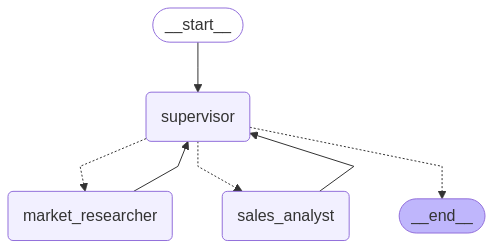

# Invocation Examples

In this section we demonstrate how to use the compiled supervisor workflow. It sets up a configuration for managing conversation state (like a session ID) and then runs the workflow with three different example queries. Each query is designed to test different aspects of the multi-agent system, such as delegation to specific agents, use of various tools, and handling of multi-step reasoning. The final response from the system and the full conversation history are printed for inspection.

The three examples presented below showcase different capabilities:
*   **Example 1:** Combines internal product lookup (Market Researcher) and external web search (Market Researcher).
*   **Example 2:** Involves internal sales data retrieval (Sales Analyst) and a subsequent calculation (Sales Analyst).
*   **Example 3:** A more complex query requiring multiple steps: web search (Market Researcher), calculation (Sales Analyst), internal sales data retrieval (Sales Analyst), and then more calculations (Sales Analyst) involving data from different sources. This demonstrates the supervisor's ability to orchestrate a sequence of actions across different agents.


In [14]:
user_config = {'configurable': {'thread_id': '1', "user_id": 'user123'}}
# we are setting up a configuration using a thread_id and user_id, this helps the system to maintain context across multiple interactions within a session.

**Example 1**

In [15]:
query = "What are the key features of our 'QuantumLeap Laptop' and what's the latest news about its competitor, the 'Apple MacBook Pro'?"

In [16]:
response = supervisor_agent_workflow.invoke(
    {"messages": [{"role": "user", "content": query}]},
    config=user_config
)

In [17]:
print(response['messages'][-1].content)

Here is the information you requested:

### QuantumLeap Laptop Key Features
- **Category**: Premium Laptop
- **CPU**: NextGen Core Ultra 9
- **RAM**: 32 GB
- **Storage**: 2 TB
- **MSRP**: $1999.99
- **Key Features**:
  - AI-Boosted Performance
  - OLED Display
  - Lightweight Chassis

### Latest News on Apple MacBook Pro
1. **Upcoming Models**: Apple is expected to refresh its MacBook Pro lineup with M5 Pro and M5 Max chips in early 2026, featuring faster SSD performance and higher memory bandwidth. OLED displays are anticipated for future models by late 2026 or early 2027.

2. **Current Pricing**: The newest MacBook Pro with the M5 chip is available at a reduced price of $1,349 on Amazon, down from the original $1,599. This model includes a 512GB SSD and represents a significant performance upgrade.

3. **Features**: The 14-inch and 16-inch MacBook Pro models feature M5, M4 Pro, and M4 Max chips, mini-LED displays, and MagSafe fast charging. Future models might include 5G connectivity

In [18]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

What are the key features of our 'QuantumLeap Laptop' and what's the latest news about its competitor, the 'Apple MacBook Pro'?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_market_researcher (call_qnD7JRHJ8LqNdfZ35ELKznC6)
 Call ID: call_qnD7JRHJ8LqNdfZ35ELKznC6
  Args:
================================= Tool Message =================================
Name: transfer_to_market_researcher

Successfully transferred to market_researcher
================================== Ai Message ==================================
Name: market_researcher

### QuantumLeap Laptop Key Features
- **Category**: Premium Laptop
- **CPU**: NextGen Core Ultra 9
- **RAM**: 32 GB
- **Storage**: 2 TB
- **MSRP**: $1999.99
- **Key Features**:
  - AI-Boosted Performance
  - OLED Display
  - Lightweight Chassis

### Latest News on Apple MacBook Pro
1. **Upcoming M

**Example 2**

In [19]:
query = """
How many units of the 'QuantumLeap Laptop' did we sell in Q1 2024?
Calculate the projected units for Q2 2024 if we expect a 15% increase.
"""

In [20]:
response = supervisor_agent_workflow.invoke(
    {"messages": [{"role": "user", "content": query}]},
    config=user_config
)

In [21]:
print(response['messages'][-1].content)

In Q1 2024, we sold 5,100 units of the 'QuantumLeap Laptop'. For Q2 2024, with an expected 15% increase in sales, we project to sell approximately 5,865 units.

If you need further assistance, feel free to ask!


In [22]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

What are the key features of our 'QuantumLeap Laptop' and what's the latest news about its competitor, the 'Apple MacBook Pro'?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_market_researcher (call_qnD7JRHJ8LqNdfZ35ELKznC6)
 Call ID: call_qnD7JRHJ8LqNdfZ35ELKznC6
  Args:
================================= Tool Message =================================
Name: transfer_to_market_researcher

Successfully transferred to market_researcher
================================== Ai Message ==================================
Name: market_researcher

### QuantumLeap Laptop Key Features
- **Category**: Premium Laptop
- **CPU**: NextGen Core Ultra 9
- **RAM**: 32 GB
- **Storage**: 2 TB
- **MSRP**: $1999.99
- **Key Features**:
  - AI-Boosted Performance
  - OLED Display
  - Lightweight Chassis

### Latest News on Apple MacBook Pro
1. **Upcoming M

**Example 3**

In [23]:
query = (
    "Search for the current price of the Apple MacBook Pro (14-inch, M4 Pro). Estimate the revenue for this product in Q1 2024 if they hypothetically sold 4800 units at that price. "
    " Retrieve our QuantumLeap Laptop's revenue for Q1 2024. Compare the difference between our Q1 2024 revenue for our QuantumLeap Laptop and the MacBook Pro's estimated revenue. "
    "What percentage difference would that be? "
)

In [24]:
response = supervisor_agent_workflow.invoke(
    {"messages": [{"role": "user", "content": query}]},
    config=user_config
)

In [25]:
print(response['messages'][-1].content)

Here's the detailed analysis:

### Current Price and Revenue Estimations
- **Apple MacBook Pro (14-inch, M4 Pro) Current Price**: $1,749
- **Estimated Revenue for Apple MacBook Pro (Q1 2024)**:
  - Units Sold: 4,800
  - Estimated Revenue: $8,395,200

- **QuantumLeap Laptop Revenue (Q1 2024)**:
  - Units Sold: 5,100
  - Price per Unit: $1,999.99
  - Revenue: $10,199,949

### Revenue Comparison
- **Difference in Revenue**: $1,804,749
- **Percentage Difference**: The QuantumLeap Laptop's revenue is approximately 21.5% higher than the estimated revenue for the MacBook Pro.

If you have any more questions or need further assistance, feel free to ask!


In [26]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

What are the key features of our 'QuantumLeap Laptop' and what's the latest news about its competitor, the 'Apple MacBook Pro'?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_market_researcher (call_qnD7JRHJ8LqNdfZ35ELKznC6)
 Call ID: call_qnD7JRHJ8LqNdfZ35ELKznC6
  Args:
================================= Tool Message =================================
Name: transfer_to_market_researcher

Successfully transferred to market_researcher
================================== Ai Message ==================================
Name: market_researcher

### QuantumLeap Laptop Key Features
- **Category**: Premium Laptop
- **CPU**: NextGen Core Ultra 9
- **RAM**: 32 GB
- **Storage**: 2 TB
- **MSRP**: $1999.99
- **Key Features**:
  - AI-Boosted Performance
  - OLED Display
  - Lightweight Chassis

### Latest News on Apple MacBook Pro
1. **Upcoming M

 - Example 4

In [27]:
query = (
    "Search for the product features for Apple MacBook Pro (14-inch, M4 Pro). Compare them to QuantumLeap Laptop. Share the brief summary with me."
)

In [28]:
response = supervisor_agent_workflow.invoke(
    {"messages": [{"role": "user", "content": query}]},
    config=user_config
)

In [29]:
print(response['messages'][-1].content)

Here's a brief comparison between the QuantumLeap Laptop and the Apple MacBook Pro (14-inch, M4 Pro):

### QuantumLeap Laptop
- **CPU**: NextGen Core Ultra 9
- **RAM**: 32 GB
- **Storage**: 2 TB
- **Display**: OLED
- **Key Features**:
  - AI-Boosted Performance
  - Lightweight Chassis
- **MSRP**: $1,999.99

### Apple MacBook Pro (14-inch, M4 Pro)
- **CPU**: Apple M4 Pro with up to 14-core CPU
- **RAM**: 16 GB (upgradable to 32 GB)
- **Storage**: 512 GB or 1 TB SSD (configurable)
- **Display**: 14.2" Liquid Retina XDR
- **Key Features**:
  - 10-core GPU
  - 16-core Neural Engine
  - Thunderbolt 5 ports
  - Advanced 12MP Center Stage camera
  - Nano-texture display option
- **MSRP**: Starts at $1,999

### Key Differences
- **Performance**: The MacBook Pro's M4 Pro chip is optimized for efficiency and graphics, while the QuantumLeap focuses on AI-enhanced performance.
- **Display**: The MacBook Pro offers a high-resolution Liquid Retina XDR display, whereas the QuantumLeap features an OLE

In [30]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

What are the key features of our 'QuantumLeap Laptop' and what's the latest news about its competitor, the 'Apple MacBook Pro'?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_market_researcher (call_qnD7JRHJ8LqNdfZ35ELKznC6)
 Call ID: call_qnD7JRHJ8LqNdfZ35ELKznC6
  Args:
================================= Tool Message =================================
Name: transfer_to_market_researcher

Successfully transferred to market_researcher
================================== Ai Message ==================================
Name: market_researcher

### QuantumLeap Laptop Key Features
- **Category**: Premium Laptop
- **CPU**: NextGen Core Ultra 9
- **RAM**: 32 GB
- **Storage**: 2 TB
- **MSRP**: $1999.99
- **Key Features**:
  - AI-Boosted Performance
  - OLED Display
  - Lightweight Chassis

### Latest News on Apple MacBook Pro
1. **Upcoming M

**Example 5**

In [31]:
query = (
    "I am a Data Scientist and Data Engineer. On a daily basis, I create LLM based agents (single/multiple), and build multi-modal RAGs."
    "I am looking for an appropriate laptop for better functioning."
    "In between Apple MacBook Pro (14-inch, M4 Pro) and QuantumLeap Laptop. Which one should I consider? Share the brief summary with me."
)

response = supervisor_agent_workflow.invoke(
    {"messages": [{"role": "user", "content": query}]},
    config=user_config
)

print(response['messages'][-1].content)

Based on your professional needs as a Data Scientist and Data Engineer, here's a brief summary to help you decide between the Apple MacBook Pro (14-inch, M4 Pro) and the QuantumLeap Laptop:

### QuantumLeap Laptop
- **CPU**: NextGen Core Ultra 9
- **RAM**: 32 GB
- **Storage**: 2 TB
- **Display**: OLED
- **Key Features**:
  - AI-Boosted Performance
  - Lightweight Chassis
- **MSRP**: $1,999.99

### Apple MacBook Pro (14-inch, M4 Pro)
- **CPU**: Apple M4 Pro with up to 14-core CPU
- **RAM**: 16 GB (upgradable to 32 GB)
- **Storage**: 512 GB or 1 TB SSD (configurable)
- **Display**: 14.2" Liquid Retina XDR
- **Key Features**:
  - 10-core GPU
  - 16-core Neural Engine
  - Thunderbolt 5 ports
  - Advanced 12MP Center Stage camera
  - Nano-texture display option
- **MSRP**: Starts at $1,999

### Considerations for Your Work
- **Performance Needs**: Both laptops offer high performance, but the QuantumLeap's AI-boosted capabilities and larger RAM might be more beneficial for running complex ma

In [32]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

What are the key features of our 'QuantumLeap Laptop' and what's the latest news about its competitor, the 'Apple MacBook Pro'?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_market_researcher (call_qnD7JRHJ8LqNdfZ35ELKznC6)
 Call ID: call_qnD7JRHJ8LqNdfZ35ELKznC6
  Args:
================================= Tool Message =================================
Name: transfer_to_market_researcher

Successfully transferred to market_researcher
================================== Ai Message ==================================
Name: market_researcher

### QuantumLeap Laptop Key Features
- **Category**: Premium Laptop
- **CPU**: NextGen Core Ultra 9
- **RAM**: 32 GB
- **Storage**: 2 TB
- **MSRP**: $1999.99
- **Key Features**:
  - AI-Boosted Performance
  - OLED Display
  - Lightweight Chassis

### Latest News on Apple MacBook Pro
1. **Upcoming M